In [1]:
import sys
import re
import os
import shutil

from sklearn.decomposition import FastICA
# import xlrd
import math
import csv
import cv2
import numpy as np
from math import *
from scipy import signal
import scipy
from scipy import interpolate
from scipy import signal
import pickle
import matplotlib.pyplot as plt





In [6]:
with open("stmaps.pickle", "rb") as file: # "rb" for read binary
    STMap_repo = pickle.load(file)
    
fileRoot = r'/home/daevinci/Datasets/DATASET_2'
subject_list = sorted(os.listdir(fileRoot))
print(subject_list)

['subject1', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject15', 'subject16', 'subject17', 'subject18', 'subject20', 'subject22', 'subject23', 'subject24', 'subject25', 'subject26', 'subject27', 'subject3', 'subject30', 'subject31', 'subject32', 'subject33', 'subject34', 'subject35', 'subject36', 'subject37', 'subject38', 'subject39', 'subject4', 'subject40', 'subject41', 'subject42', 'subject43', 'subject44', 'subject45', 'subject46', 'subject47', 'subject48', 'subject49', 'subject5', 'subject8', 'subject9']


In [7]:
print(STMap_repo[0].shape)

(25, 1547, 3)


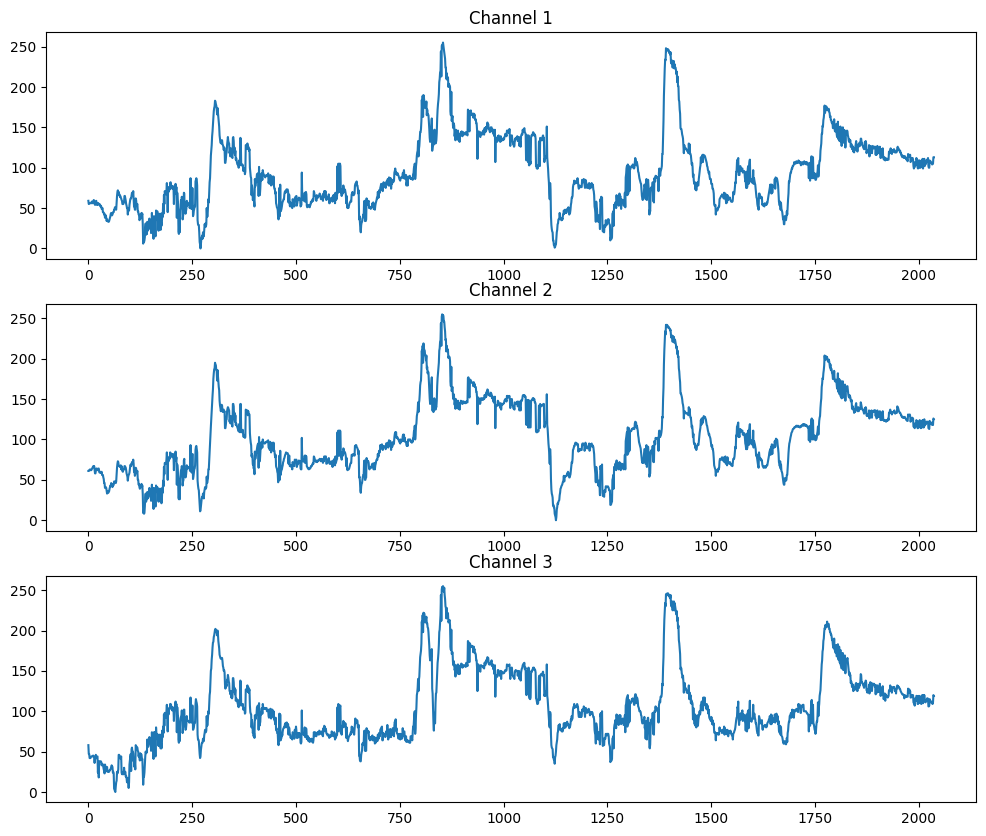

In [8]:
plt.figure(figsize=(12, 10))
K = 3
subject = 30
region= 8
for i in range(K):
    plt.subplot(K, 1, i+1)
    plt.plot(STMap_repo[subject][region,:,i])
    plt.title(f'Channel {i+1}')
plt.show()

In [9]:
ica = FastICA(n_components = K)
components = ica.fit_transform(STMap_repo[subject][region,:,:])
components.shape

(2037, 3)

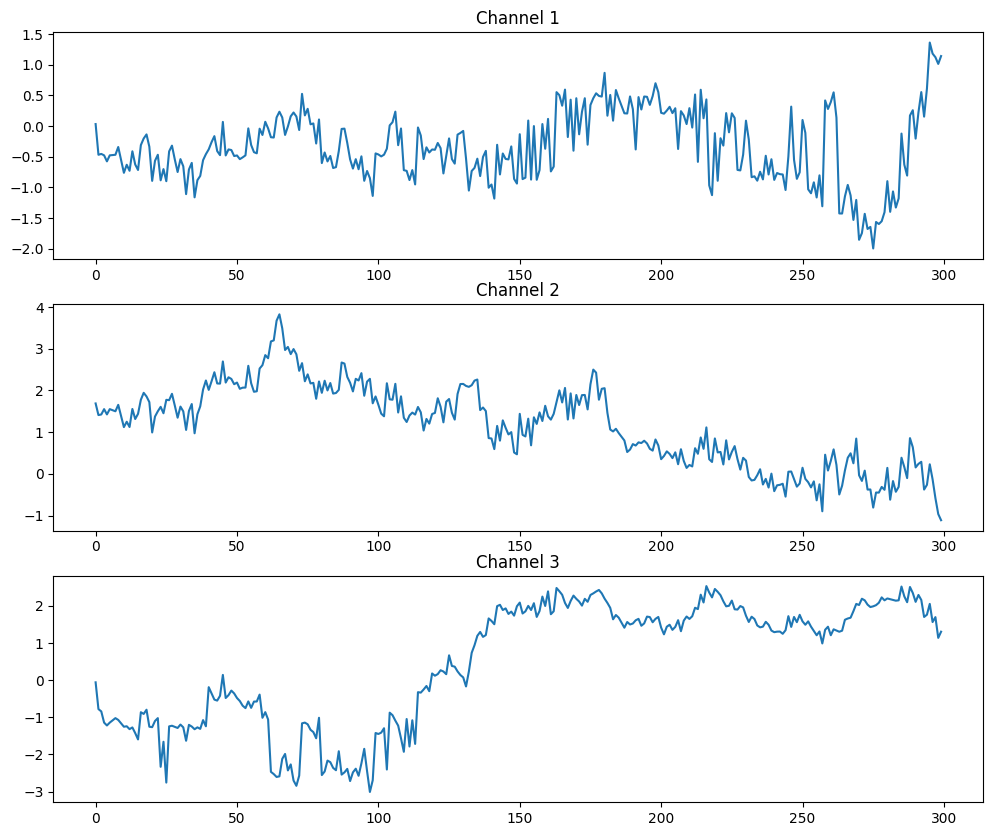

In [10]:
plt.figure(figsize = (12,10))
for i in range(K):
    plt.subplot(K, 1, i+1)
    plt.plot(components[:300, i])
    plt.title(f'Channel {i+1}')
plt.show()

In [11]:
dataset_path = f"/home/daevinci/Datasets/DATASET_2"

subject_dirs = sorted(os.listdir(dataset_path))

bvp_repo = []
for sub in subject_dirs:
    path = os.path.join(dataset_path, sub, "Label/BVP.mat")
    print(path)
    bvp = scipy.io.loadmat(path)
    bvp_repo.append(bvp['BVP'].squeeze())
    
print(bvp_repo[0].shape)


/home/daevinci/Datasets/DATASET_2/subject1/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject10/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject11/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject12/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject13/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject14/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject15/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject16/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject17/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject18/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject20/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject22/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject23/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject24/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject25/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject26/Label/BVP.mat
/home/daevinci/Datasets/DATASET_2/subject27/Label/BVP.mat
/home/daevinci/

In [12]:
bvp = np.expand_dims(bvp_repo[subject], axis = 0)
bvp = np.resize(bvp, (1,components.shape[0]))
# bvp = np.repeat(bvp, repeats = 3, axis = 0)
print(bvp.shape)
cross_corr=  np.corrcoef(components.T, bvp)
cross_corr[:,3]

(1, 2037)


array([ 0.02367947, -0.04374971,  0.04414459,  1.        ])

## CHROM

In [13]:
# Set subject number
subject = 10

In [14]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

def bandpass(signal, fs=30, low=0.7, high=4.0, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)

def chrom_method(rgb_ts, fs=30):
    """Input: rgb_ts shape = (T, 3)"""
    r = rgb_ts[:, 0]
    g = rgb_ts[:, 1]
    b = rgb_ts[:, 2]

    r = (r - np.mean(r)) / (np.std(r) + 1e-8)
    g = (g - np.mean(g)) / (np.std(g) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)

    X = 3 * r - 2 * g
    Y = 1.5 * r + g - 1.5 * b
    alpha = np.std(X) / (np.std(Y) + 1e-8)

    s = X - alpha * Y
    return bandpass(s, fs)


In [15]:
def compute_and_plot_region_chrom(regions_rgb, fs=30):
    """
    regions_rgb: shape (25, T, 3)
    Computes CHROM signals and plots them vertically with wide plots.
    """
    chroms = []
    plt.figure(figsize=(12, 2 * regions_rgb.shape[0]))  # Tall figure

    for i in range(regions_rgb.shape[0]):
        chrom_sig = chrom_method(regions_rgb[i], fs)
        chroms.append(chrom_sig)

        plt.subplot(regions_rgb.shape[0], 1, i + 1)
        plt.plot(chrom_sig, color='purple', linewidth=2)
        plt.title(f'Region {i + 1}', fontsize=10)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

    plt.suptitle('CHROM Signals per Region (Vertical)', fontsize=16, y=1.02)
    plt.show()

    return np.array(chroms)

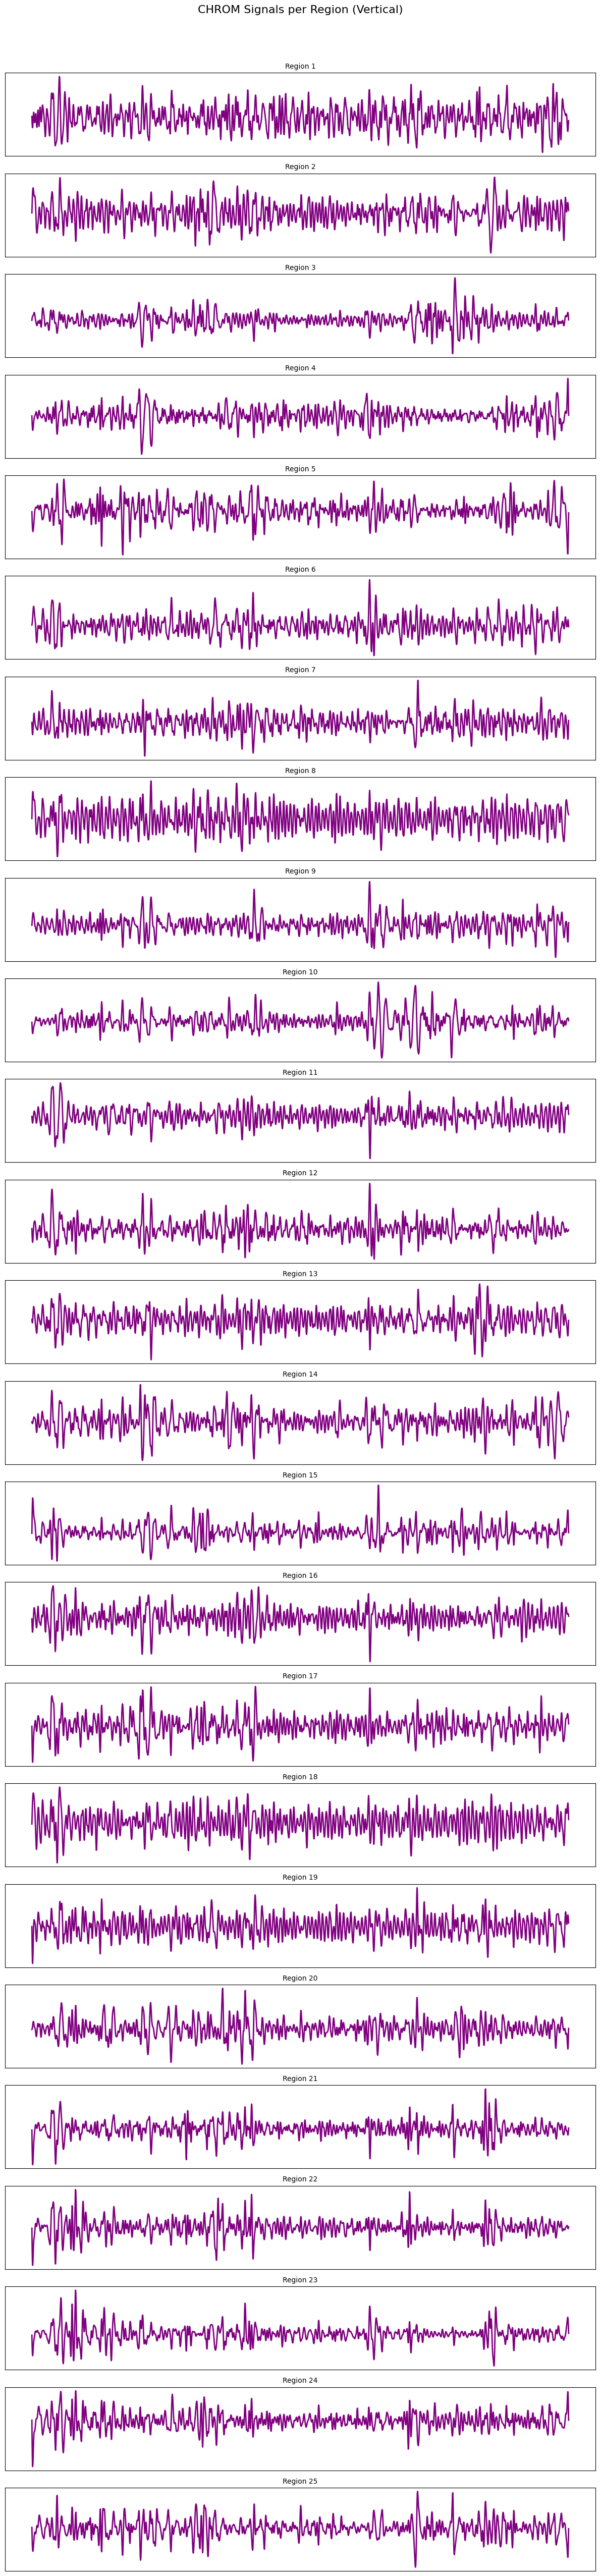

In [16]:

chroms = compute_and_plot_region_chrom(STMap_repo[subject])

#### Inter-Region Correlation

In [20]:
import seaborn as sns

def plot_region_correlation_heatmap(chrom_signals, title='Inter-region Correlation Heatmap'):
    """
    chrom_signals: np.array of shape (25, T) — CHROM signals per region
    Plots a 25x25 heatmap showing Pearson correlation between every pair of regions.
    """
    n = chrom_signals.shape[0]
    corr_matrix = np.corrcoef(chrom_signals)
    plt.figure(figsize=(8, 7))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1,
                xticklabels=[f'Reg {i+1}' for i in range(n)],
                yticklabels=[f'Reg {i+1}' for i in range(n)],
                square=True, linewidths=0.3, linecolor='gray',
                cbar_kws={'label': 'Pearson Correlation'})
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


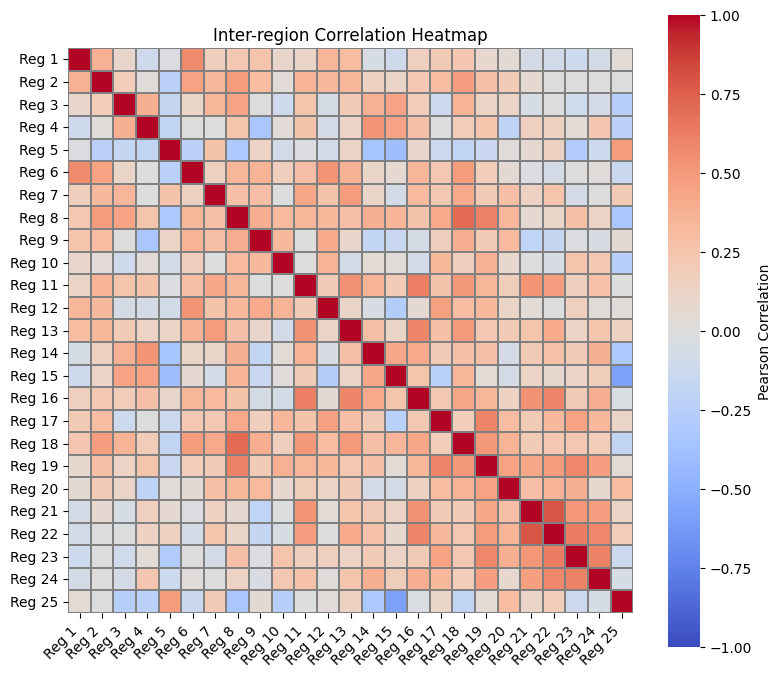

In [21]:
plot_region_correlation_heatmap(chroms)

#### Region Correlation with Ground Truth

In [22]:

def compute_region_correlations(regions_rgb, gt_rppg, fs=30):
    """
    regions_rgb: shape (25, T, 3)
    gt_rppg: shape (T,)
    """
    
    min_len = min(regions_rgb.shape[1], len(gt_rppg))
    regions_rgb = regions_rgb[:, :min_len, :]
    gt_rppg = gt_rppg[:min_len]
    gt_filtered = bandpass(gt_rppg, fs)
    corrs = []
    for i in range(regions_rgb.shape[0]):
        chrom_sig = chrom_method(regions_rgb[i], fs)
        corr = np.corrcoef(chrom_sig, gt_filtered)[0, 1]
        corrs.append(corr)
    return np.array(corrs)

def plot_heatmap(corrs, title='CHROM Correlation with GT rPPG'):
    # Reshape into 5x5 grid
    heatmap_data = corrs.reshape(5, 5)

    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', square=True,
                vmin=-1, vmax=1, linewidths=0.5, linecolor='black',
                cbar_kws={"label": "Pearson Correlation"})
    plt.title(title)
    plt.xlabel('Region X')
    plt.ylabel('Region Y')
    plt.tight_layout()
    plt.show()


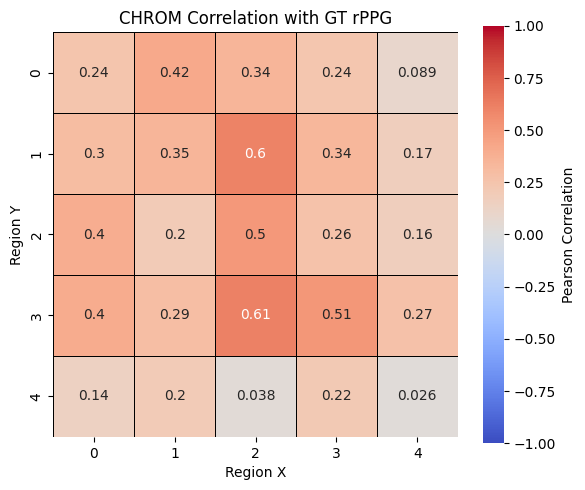

In [23]:
correlations = compute_region_correlations(STMap_repo[subject], bvp_repo[subject], fs=30)
plot_heatmap(correlations)

#### Same, but with PSDs

In [34]:
from scipy.signal import welch

def compute_psd(signal, fs=30, nperseg=2048):
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    return freqs, psd

def compute_psd_correlations(chrom_signals, gt_rppg, fs=30):
    """
    chrom_signals: shape (25, T)
    gt_rppg: shape (T,)
    """
    # Compute GT PSD
    freqs_gt, psd_gt = compute_psd(gt_rppg, fs)
    psd_corrs = []
    region_psds = []

    for i in range(chrom_signals.shape[0]):
        freqs_r, psd_r = compute_psd(chrom_signals[i], fs)
        region_psds.append(psd_r)
        corr = np.corrcoef(psd_gt, psd_r)[0, 1]
        psd_corrs.append(corr)

    psd_corrs = np.array(psd_corrs)
    region_psds = np.array(region_psds)

    # Plot heatmap
    heatmap_data = psd_corrs.reshape(5, 5)
    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1,
                linewidths=0.5, linecolor='black', square=True,
                cbar_kws={'label': 'Pearson Correlation (PSD)'})
    plt.title('PSD Correlation with Ground Truth')
    plt.xlabel('Region X')
    plt.ylabel('Region Y')
    plt.tight_layout()
    plt.show()

    # Plot best region's PSD vs GT
    best_idx = np.argmin(psd_corrs)
    best_psd = region_psds[best_idx]

    # Scale best region's PSD to match GT power
    scale_factor = np.sum(psd_gt) / (np.sum(best_psd) + 1e-8)
    best_psd_scaled = best_psd * scale_factor

    plt.figure(figsize=(10, 4))
    plt.plot(freqs_gt, psd_gt, label='GT rPPG', linewidth=2)
    plt.plot(freqs_gt, best_psd_scaled, label=f'Best Region {best_idx + 1} (scaled)', linewidth=2)

    plt.xlim(0.5, 5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(f'PSD Comparison: GT vs Best Region {best_idx + 1} (Corr={psd_corrs[best_idx]:.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return psd_corrs

/tmp/ipykernel_7726/737043463.py:4: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 2016, using nperseg = 2016
  freqs, psd = welch(signal, fs=fs, nperseg=nperseg)


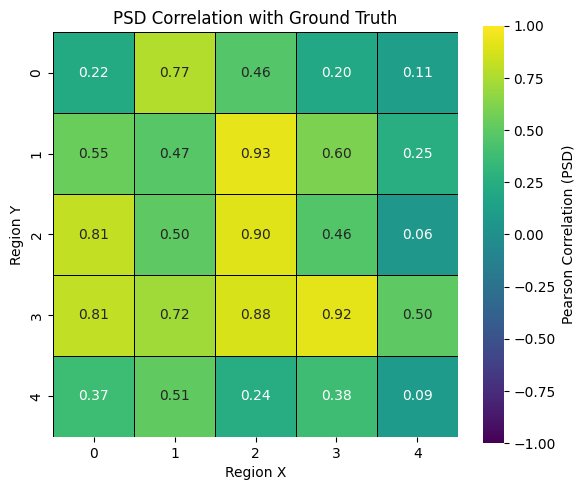

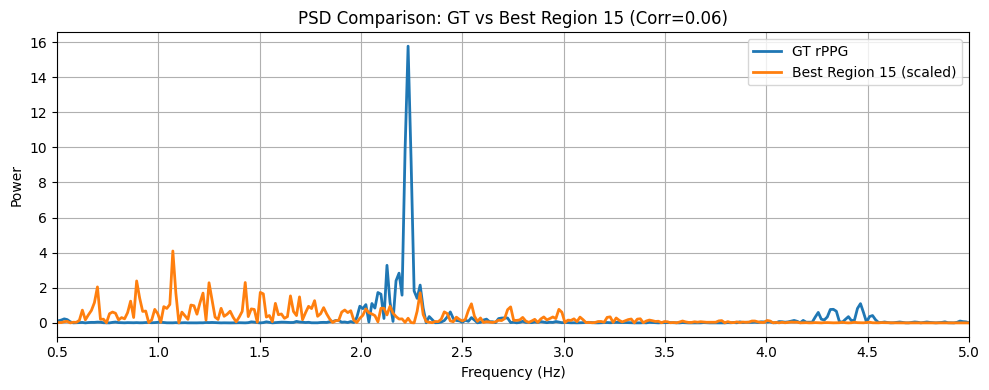

In [35]:
psd_corrs = compute_psd_correlations(chroms, bvp_repo[subject], fs=30)


#### Coherence

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence, resample, welch, butter, filtfilt
from scipy.fft import fft, fftfreq

def bandpass_filter(signal, fs, low=0.5, high=10, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)

def bandpass_mask(frequencies, low=0.7, high=4.0):
    return (frequencies >= low) & (frequencies <= high)

def chrom_method(rgb_signal, fs=30):
    """
    rgb_signal: (T, 3)
    Output: chrom signal: (T,)
    """
    X = rgb_signal.T  # shape (3, T)
    Xc = X - np.mean(X, axis=1, keepdims=True)

    # Projection
    A = np.array([[3, -2, 0], [1.5, 1, -1.5]])
    Y = A @ Xc  # shape (2, T)
    stds = np.std(Y, axis=1, keepdims=True)
    Y = Y / (stds + 1e-8)

    chrom = Y[0] - Y[1]
    return chrom

def analyze_chrom_coherence_and_psd(regions_rgb, gt_rppg, fs_rgb=30, fs_gt=60):
    """
    regions_rgb: (25, T, 3)
    gt_rppg: (T_gt,)
    """
    num_regions, T, _ = regions_rgb.shape

    # Step 1: Resample GT to match RGB FPS
    gt_rppg_resampled = resample(gt_rppg, T)
    gt_rppg_filtered = bandpass_filter(gt_rppg_resampled, fs=fs_rgb)

    coh_scores = np.zeros(num_regions)
    best_coh = -np.inf
    best_idx = 0

    chrom_signals = []

    # Step 2: Compute CHROM signal per region
    for i in range(num_regions):
        chrom_sig = chrom_method(regions_rgb[i], fs=fs_rgb)
        chrom_sig_filtered = bandpass_filter(chrom_sig, fs=fs_rgb)
        chrom_signals.append(chrom_sig_filtered)

        f, coh = coherence(chrom_sig_filtered, gt_rppg_filtered, fs=fs_rgb, nperseg=1024)
        mask = bandpass_mask(f)
        score = np.mean(coh[mask])
        coh_scores[i] = score

        if score > best_coh:
            best_coh = score
            best_idx = i

    chrom_signals = np.array(chrom_signals)

    # Step 3: Plot Coherence Heatmap
    plt.figure(figsize=(10, 3))
    plt.imshow(coh_scores[None, :], cmap='viridis', aspect='auto')
    plt.xlabel("Region")
    plt.yticks([0], ["CHROM"])
    plt.title("Mean Welch Coherence (CHROM vs GT, 0.7–4Hz)")
    plt.colorbar(label="Coherence")
    plt.tight_layout()
    plt.show()

    # Step 4: Plot FFT PSDs of best region
    best_chrom = chrom_signals[best_idx]
    best_chrom = bandpass_filter(best_chrom, fs=fs_rgb)

    N = len(best_chrom)
    freqs_chrom = fftfreq(N, d=1/fs_rgb)[:N//2]
    psd_chrom = np.abs(fft(best_chrom))[:N//2] ** 2

    N_gt = len(gt_rppg_filtered)
    freqs_gt = fftfreq(N_gt, d=1/fs_rgb)[:N_gt//2]
    psd_gt = np.abs(fft(gt_rppg_filtered))[:N_gt//2] ** 2

    psd_chrom /= np.sum(psd_chrom)
    psd_gt /= np.sum(psd_gt)

    plt.figure(figsize=(10, 4))
    plt.plot(freqs_gt, psd_gt, label='GT rPPG (FFT)', linewidth=2)
    plt.plot(freqs_chrom, psd_chrom, label=f'Best Region {best_idx+1} CHROM (FFT)', linewidth=2)
    plt.xlim(0, 5)
    plt.title("FFT PSD of Best CHROM Region vs GT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 5: Welch PSD of best region
    f_chrom, psd_chrom_welch = welch(best_chrom, fs=fs_rgb, nperseg=1024)
    f_gt, psd_gt_welch = welch(gt_rppg_filtered, fs=fs_rgb, nperseg=1024)

    psd_chrom_welch /= np.sum(psd_chrom_welch)
    psd_gt_welch /= np.sum(psd_gt_welch)

    plt.figure(figsize=(10, 4))
    plt.plot(f_gt, psd_gt_welch, label='GT rPPG (Welch)', linewidth=2)
    plt.plot(f_chrom, psd_chrom_welch, label=f'Best Region {best_idx+1} CHROM (Welch)', linewidth=2)
    plt.xlim(0, 5)
    plt.title("Welch PSD of Best CHROM Region vs GT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return coh_scores, best_idx


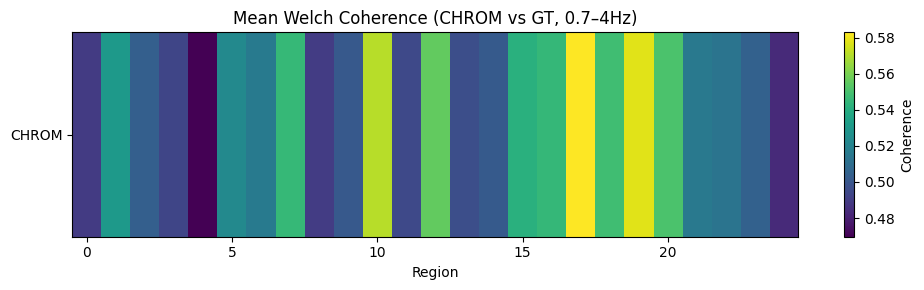

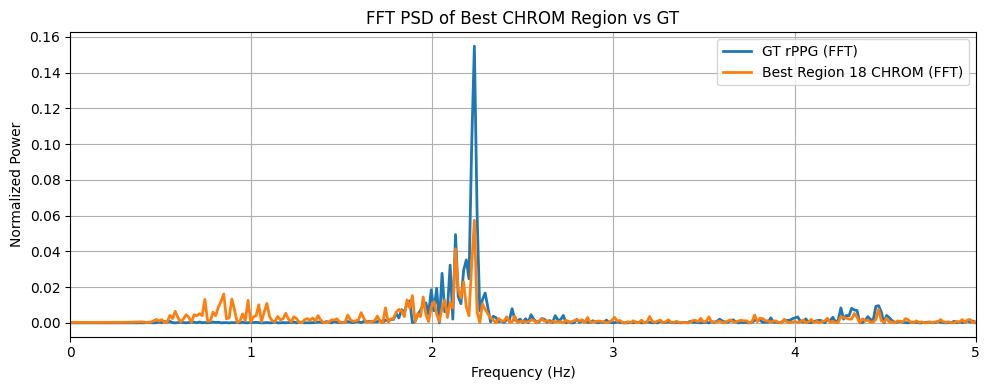

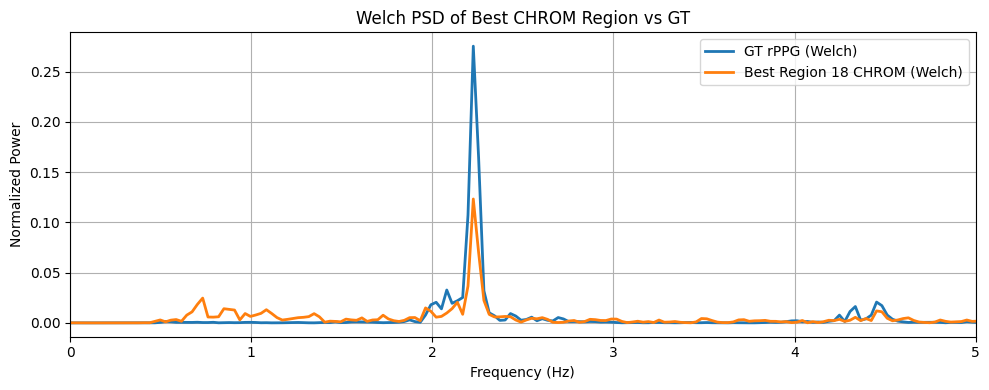

In [27]:
coh_scores, best_idx = analyze_chrom_coherence_and_psd(STMap_repo[subject], bvp_repo[subject], fs_rgb=30, fs_gt=60)


CHROM stuff ends here

In [42]:
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_psd(signal, fs=30, nperseg=1024):
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    return freqs, psd

def analyze_rgb_psd_correlation_with_gt(regions_rgb, gt_rppg, fs=30):
    """
    regions_rgb: (25, T, 3)
    gt_rppg: shape (T,)
    """

    channels = ['R', 'G', 'B']
    psd_corrs_all = []  # shape: (3, 25)
    region_psds_all = []  # shape: (3, 25, F)

    freqs_gt, psd_gt = compute_psd(gt_rppg, fs)

    for c in range(3):
        psd_corrs = []
        region_psds = []
        for i in range(regions_rgb.shape[0]):
            signal = regions_rgb[i, :, c]
            _, psd = compute_psd(signal, fs)
            corr = np.corrcoef(psd_gt, psd)[0, 1]
            psd_corrs.append(corr)
            region_psds.append(psd)
        psd_corrs_all.append(psd_corrs)
        region_psds_all.append(region_psds)

    psd_corrs_all = np.array(psd_corrs_all)      # (3, 25)
    region_psds_all = np.array(region_psds_all)  # (3, 25, F)

    # Plot heatmaps for each channel
    for c in range(3):
        plt.figure(figsize=(6, 5))
        sns.heatmap(psd_corrs_all[c].reshape(5, 5), annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1,
                    linewidths=0.5, linecolor='black', square=True,
                    cbar_kws={'label': f'PSD Correlation (Channel {channels[c]})'})
        plt.title(f'PSD Correlation: Channel {channels[c]}')
        plt.xlabel('Region X')
        plt.ylabel('Region Y')
        plt.tight_layout()
        plt.show()

    # Find best correlation across all channels and regions
    best_channel, best_region = np.unravel_index(np.argmax(psd_corrs_all), psd_corrs_all.shape)
    best_psd = region_psds_all[best_channel, best_region]

    # 🔥 Scale the best PSD to match GT
    scale_factor = np.sum(psd_gt) / (np.sum(best_psd) + 1e-8)
    best_psd_scaled = best_psd * scale_factor 

    # Plot overlay
    plt.figure(figsize=(10, 4))
    plt.plot(freqs_gt, psd_gt/20, label='GT rPPG', linewidth=2)
    plt.plot(freqs_gt, best_psd_scaled, label=f'Best Region {best_region + 1} - {channels[best_channel]} (scaled)', linewidth=2)
    plt.xlim(0.5, 5)
    plt.ylim(0,1)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(f'PSD Comparison: GT vs Best RGB Channel (Corr={psd_corrs_all[best_channel, best_region]:.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return psd_corrs_all


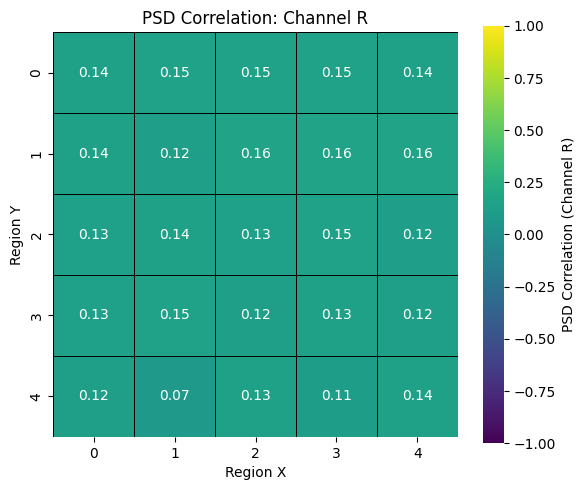

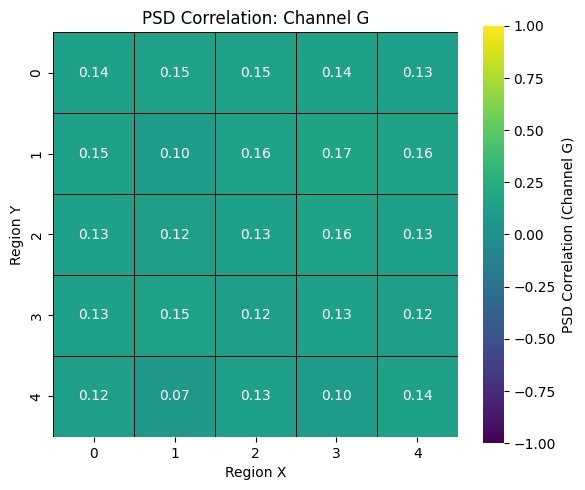

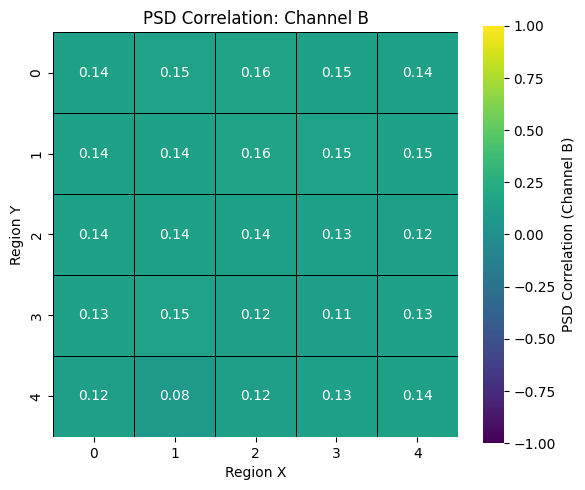

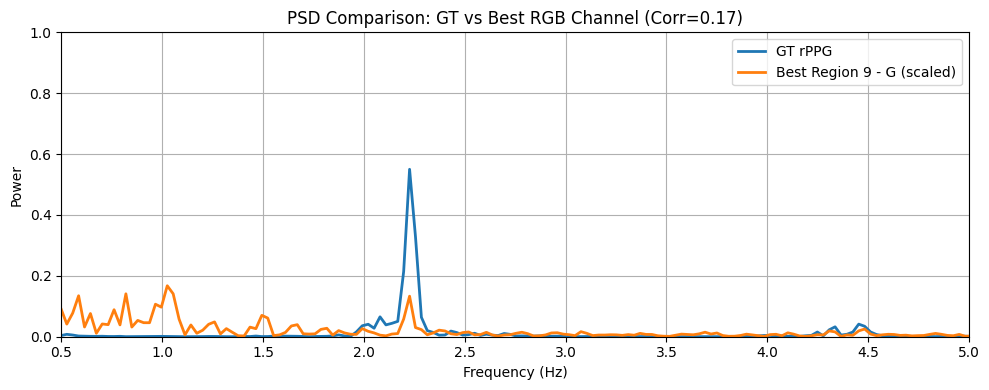

In [43]:
psd_corrs_rgb = analyze_rgb_psd_correlation_with_gt(STMap_repo[subject], bvp_repo[subject], fs=30)

#### Coherence

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence, resample, welch, butter, filtfilt
from scipy.fft import fft, fftfreq

def bandpass_filter(signal, fs, low=0.5, high=10, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)

def bandpass_mask(frequencies, low=0.7, high=4.0):
    return (frequencies >= low) & (frequencies <= high)

def analyze_rgb_coherence_and_psd(regions_rgb, gt_rppg, fs_rgb=30, fs_gt=60):
    """
    regions_rgb: (25, T, 3)
    gt_rppg: (T_gt,)
    """
    num_regions, T, _ = regions_rgb.shape
    num_channels = 3

    # --- Step 1: Resample GT to match RGB FPS ---
    gt_rppg_resampled = resample(gt_rppg, T)
    gt_rppg_filtered = bandpass_filter(gt_rppg_resampled, fs=fs_rgb)

    coh_scores = np.zeros((num_channels, num_regions))
    best_coh = -np.inf
    best_idx = (0, 0)

    # --- Step 2: Compute Welch-based Coherence on bandpassed signals ---
    for c in range(num_channels):
        for i in range(num_regions):
            sig_rgb = bandpass_filter(regions_rgb[i, :, c], fs=fs_rgb)
            f, coh = coherence(sig_rgb, gt_rppg_filtered, fs=fs_rgb, nperseg=2048)
            mask = bandpass_mask(f)
            score = np.mean(coh[mask])
            coh_scores[c, i] = score

            if score > best_coh:
                best_coh = score
                best_idx = (c, i)

    # --- Step 3: Plot Coherence Heatmap ---
    plt.figure(figsize=(12, 4))
    plt.imshow(coh_scores, cmap='viridis', aspect='auto')
    plt.xlabel("Region")
    plt.ylabel("Channel (0=R, 1=G, 2=B)")
    plt.title("Mean Welch Coherence with GT (0.7–4Hz)")
    plt.colorbar(label="Coherence")
    plt.tight_layout()
    plt.show()

    # --- Step 4: FFT PSD of Best Region ---
    best_c, best_r = best_idx
    best_rgb_raw = regions_rgb[best_r, :, best_c]
    best_rgb = bandpass_filter(best_rgb_raw, fs=fs_rgb)

    N = len(best_rgb)
    freqs_rgb = fftfreq(N, d=1/fs_rgb)[:N//2]
    psd_rgb = np.abs(fft(best_rgb))[:N//2] ** 2

    N_gt = len(gt_rppg_filtered)
    freqs_gt = fftfreq(N_gt, d=1/fs_rgb)[:N_gt//2]
    psd_gt = np.abs(fft(gt_rppg_filtered))[:N_gt//2] ** 2

    psd_rgb /= np.sum(psd_rgb)
    psd_gt /= np.sum(psd_gt)

    plt.figure(figsize=(10, 4))
    plt.plot(freqs_gt, psd_gt, label='GT rPPG (bandpassed, FFT)', linewidth=2)
    plt.plot(freqs_rgb, psd_rgb, label=f'Best Region {best_r+1}, Channel {best_c} (bandpassed, FFT)', linewidth=2)
    plt.xlim(0, 5)
    plt.title("FFT PSD of Best Coherence Region vs GT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Step 5: Welch PSD for comparison ---
    f_rgb, psd_rgb_welch = welch(best_rgb, fs=fs_rgb, nperseg=2048)
    f_gt, psd_gt_welch = welch(gt_rppg_filtered, fs=fs_rgb, nperseg=2048)

    psd_rgb_welch /= np.sum(psd_rgb_welch)
    psd_gt_welch /= np.sum(psd_gt_welch)

    plt.figure(figsize=(10, 4))
    plt.plot(f_gt, psd_gt_welch, label='GT rPPG (Welch)', linewidth=2)
    plt.plot(f_rgb, psd_rgb_welch, label=f'Best Region {best_r+1}, Channel {best_c} (Welch)', linewidth=2)
    plt.xlim(0, 5)
    plt.title("Welch PSD of Best Coherence Region vs GT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return coh_scores, best_r, best_c


/home/daevinci/anaconda3/envs/pytorch_base/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:2015: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 2016, using nperseg = 2016
  freqs, Pxx = welch(x, fs=fs, window=window, nperseg=nperseg,
/home/daevinci/anaconda3/envs/pytorch_base/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:2018: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 2016, using nperseg = 2016
  _, Pyy = welch(y, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
/tmp/ipykernel_7726/4165639988.py:34: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 2016, using nperseg = 2016
  f, coh = coherence(sig_rgb, gt_rppg_filtered, fs=fs_rgb, nperseg=2048)


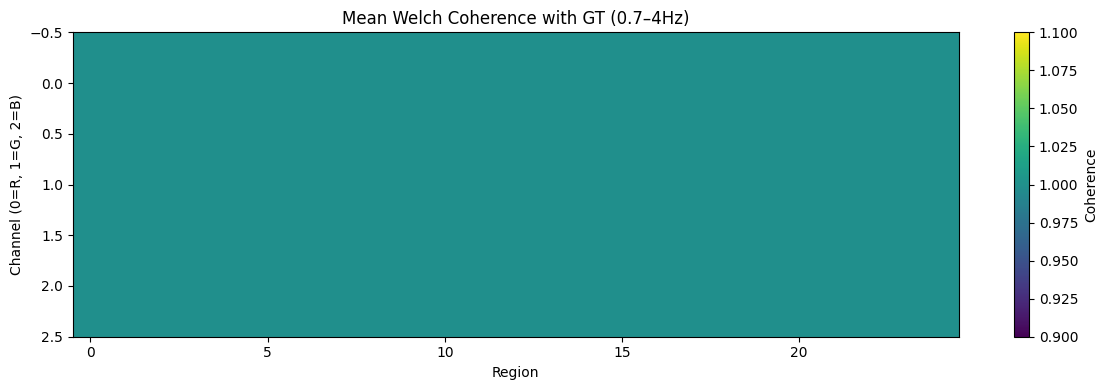

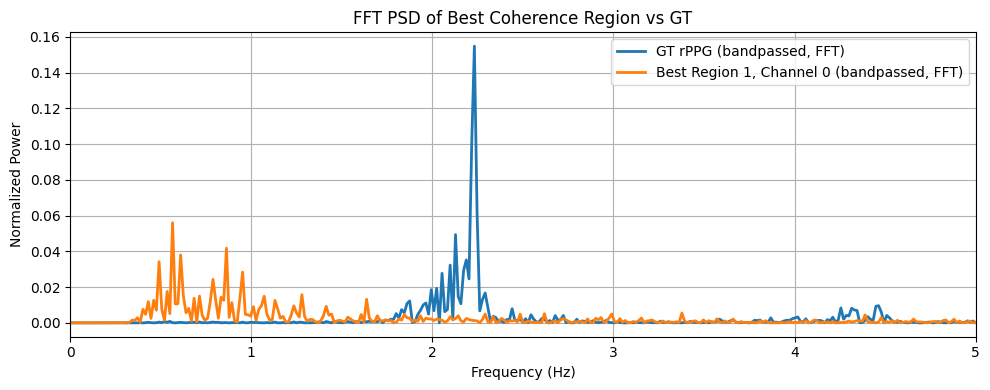

/tmp/ipykernel_7726/4165639988.py:82: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 2016, using nperseg = 2016
  f_rgb, psd_rgb_welch = welch(best_rgb, fs=fs_rgb, nperseg=2048)
/tmp/ipykernel_7726/4165639988.py:83: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 2016, using nperseg = 2016
  f_gt, psd_gt_welch = welch(gt_rppg_filtered, fs=fs_rgb, nperseg=2048)


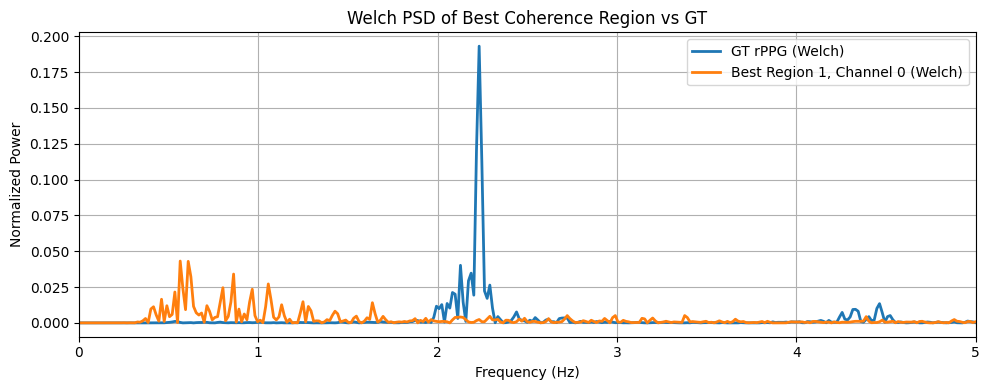

In [31]:
coh_scores, best_region, best_channel = analyze_rgb_coherence_and_psd(STMap_repo[subject], bvp_repo[subject], fs_rgb=30, fs_gt=60)
